### This project does not require Qutip

In [1]:
import numpy as np
from qutip import *
from qutip.qip.operations import rx
import scipy as sp
from scipy.optimize import curve_fit,fsolve
from scipy.special import erfc,erf
import os
import sys
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy.constants as sc

In [2]:
import scqubits as scq

In [ ]:
scq.GUI()

Container(children=[Sheet(children=[Card(children=[Img(layout=None, src='data:image/png;base64,iVBORw0KGgoAAAA…

### Readout Parameters

### When ground capcitances for JJA and phase slip junction are not the same

In [3]:
e_c=(sc.e)**2/2/sc.h/10**(-6)#e_c/C(fF)=f(in GHz). 1/10^(-6)=1/(fF*Giga)
print(e_c)
#we are using the units in which hbar=1 \implies h=2\pi. Therefore E=2\pi f.

19.37022932465912


In [4]:
#Oliver's data set 1 (all values are omega, that is E in the units of (2\pi*GHz)=\omega). That is these are not energies but frequencies!
tpi=1
N=102
EJ1=6.2*tpi# Phase-Slip junction energy. Modified from 7.3
EJJ=81.6*tpi#JJA junction energy
E_tot=1.41*tpi#target capacitance (We can achieve this using the differential capacitance upto EJ/Ec=20)
wr=8.5*tpi#readout frequency
print(E_tot)
Eg1=e_c/10*tpi#ground capciatnce for JJ
#check if target energy for C=C'+Cg1 is 1GHz
EC1=((1/E_tot-1/2/Eg1)**(-1))# Phase-Slip capacitance energy. Modified to have target capacitance equal to 1.41GHz
print((1/EC1+2/Eg1)**(-1))

#Need to ask Will Oliver to share these params with me.
Ec=e_c/1*tpi#coupling capacitance energy
Eg=e_c/0.1*tpi#ground capacitance energy
ECJ=0.74*tpi#JJA capacitance energy
Eg1=e_c/10*tpi#ground capciatnce for JJ
print(Eg1,Eg,Ec,EC1,ECJ)


1.41
0.6740342738176032
1.937022932465912 193.7022932465912 19.37022932465912 2.216843747632517 0.74


In [5]:
print(E_tot)
print(6.2/5)
print(1/(1/EC1-1/1.24))

1.41
1.24
-2.8140490776815983


### Common Parameters

In [6]:
kr=0.001#readout loss rate
Qr=wr/tpi/kr#Quality factor
print(Qr)
Z=200/np.pi#readout impedance \Ohms
Rk=25.8*10**(3)#resistance quantum. 25.8 K\Ohms
ECr=e_c/294*tpi#GHz capacitive energy of readout
ELr=137*tpi#GHz inductive energy of readout

8500.0


### E_t

In [7]:
#dominated by Eg1
Et1=((N-1)/Eg+2/Eg1+2/Ec)**(-1)
Et2=((N-1)/Eg+2/Eg1+1/Ec)**(-1)
Et3=((N-1)/Eg+1/Eg1+1/Ec)**(-1)
print(Et1,Et2,Et3)
print((N-1)/Eg,2/Eg1,2/Ec)

0.6034339353476361 0.6228369557768206 0.9180203471402427
0.5214187106779512 1.0325122983721806 0.10325122983721806


### Circuit Strengths

In [8]:
#Qubit charging energy (no change apart from Et from previous block)
G1=(1/64/Et1)*(1-(2/3)*(N**2-1)/N*(Et1/Eg))
G2=(1/64/Et2)*((1-Et2/Ec)**2)*(1-(2/3)*(N-1)/N)
G3=(1/64/Et3)*((1-Et3/Ec)**2)*(1-(2/3)*(N-2)/(N-1))
M1=1/16*(1/EC1+1/N/ECJ)
M2=1/16*(1/EC1+1/N/ECJ)
M3=1/16*(1/EC1+1/(N-1)/ECJ)
Charge1=1/16/(G1+M1)
Charge2=1/16/(G2+M2)
Charge3=1/16/(G3+M3)
print(Charge1)#in GHz
print(Charge2)#in GHz
print(Charge3)#in GHz
#We need N<<8*(np.pi**2)*Eg1/Charge1. 
#For large N we need to check for different approximation!
#print(Eg/Charge1)
#print(8*(np.pi**2))
print("Validity:",N/(8*(np.pi**2)*Eg/Charge1))

1.2644130824354534
1.6888233692893806
1.8232293643484037
Validity: 0.008432661310917449


In [9]:
((EJJ/N/8/Charge1)**(1/4))/np.sqrt(2)

0.37498401689125493

### Only N degrees of freedom inspite of N+1 junctions due to flux quantization. All graphs for parasitic modes should be plotted for array elements between 1 and N-1, since I have reserved the zeroth mode to get the right indices for odd and even modes.

0.3686901660093396


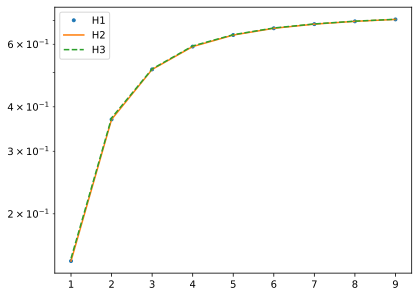

In [10]:
#Even-odd sector sector. These are omega=(2\pi) GHz and not frequency. [Charging energy for the even-odd sector]
E1=[0]
E2=[0]
E3=[0]
n=[0]
l1=(N-1)*Et1/Eg
l2=(N-1)*Et2/Eg
l3=(N-1)*Et3/Eg
def s(i,n):
    return np.sin(np.pi*i/2/n)
def c(i,n):
    return np.cos(np.pi*i/2/n)
def Ee(i,n):
    return (1/ECJ+1/(4*Eg*s(i,n)**2))**(-1)
def q(i,n):
    c1=0
    for k in range(1,n+1):
        if k!=i and np.mod(k,2)!=0:
            c1=c1+(c(k,n)**2*c(i,n)**2)/((n-1)**2*(n)**2*(s(i,n)**4*s(k,n)**2-s(i,n)**2*s(k,n)**4))
    return c1
def Eo(i,l,n):
    return (1/ECJ+1/(4*Eg*s(i,n)**2)-(l/2/Eg)*(c(i,n)**2)/(n-1)/(n)/s(i,n)**2+l**2/Eg*q(i,n))**(-1)    
for i in range(1,N):
    if np.mod(i,2)==0:
        E1.append(Ee(i,N))
        E2.append(Ee(i,N))
        E3.append(Ee(i,N-1))
    else:
        E1.append(Eo(i,l1,N))
        E2.append(Eo(i,l2,N))
        E3.append(Eo(i,l3,N-1))
    n.append(i)
plt.plot(n[1:10],E1[1:10],'.',label='H1')
plt.plot(n[1:10],E2[1:10],'-',label='H2')
plt.plot(n[1:10],E3[1:10],'--',label='H3')
plt.yscale('log')
plt.legend()
print(E1[2])

### Remember that E starts with 0 whereas i starts with 1, so value of i=1 is stored in 0. functions will take values i while arrays will take values i-1


9.806858574913383
15.513895074122967
21.96840826168761


 /var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_43510/1352605105.py: 9

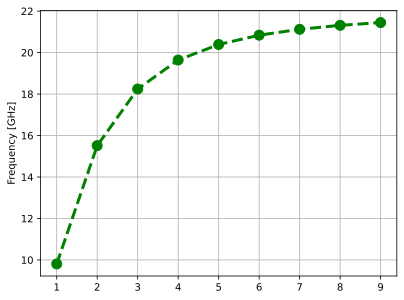

In [11]:
#Parasitic Mode Frequency in f (the E's are omegas as they are written in units of hbar!)
omega1=[0]
omega2=[0]
omega3=[0]
for i in range(1,N):
    omega1.append(np.sqrt(8*E1[i]*EJJ))
    omega2.append(np.sqrt(8*E2[i]*EJJ))
    omega3.append(np.sqrt(8*E3[i]*EJJ))
plt.plot(n[1:10],omega1[1:10],'.--',color='green',linewidth=3,marker='o',ms=10,label='H1')
#plt.plot(n[1:10],omega2[1:10],'-',label='H2')
#plt.plot(n[1:10],omega3[1:10],'--',label='H3')
plt.ylabel('Frequency [GHz]')
#plt.ylabel(r'$\omega_\rho$ [GHz/$2\pi$]')

#plt.yscale('log')
print(omega1[1])
print(omega1[2])
print(omega1[-1])
plt.grid()
np.save("freq_Will.npy",omega1)
#plt.savefig("Freq_Will.pdf")
plt.show()

8.165414563355972e-05
3.4113404128620463e-07
6.955305113525093e-10


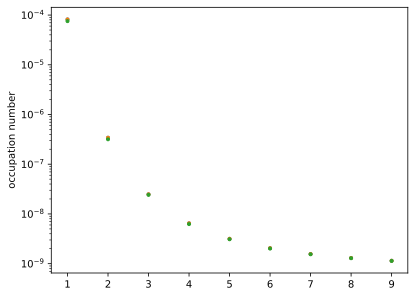

In [12]:
#occupation number of the parasitic modes
import scipy.constants as sc
T=50*10**(-3)
t=sc.h/T/sc.k/tpi
occ1=[0]
occ2=[0]
occ3=[0]
#Occupation number
for i in range(1,N):
    occ1.append(1/(np.exp(t*omega1[i]*10**9)-1))
    occ2.append(1/(np.exp(t*omega2[i]*10**9)-1))
    occ3.append(1/(np.exp(t*omega3[i]*10**9)-1))
plt.plot(n[1:10],occ1[1:10],'.',label='H1')
plt.plot(n[1:10],occ2[1:10],'.',label='H2')
plt.plot(n[1:10],occ3[1:10],'.',label='H3')
plt.yscale('log')
plt.ylabel('occupation number')
print(occ1[1])
print(occ1[2])
print(occ1[-1])

### Readout Coupling Strengths

In [13]:
#Qubit Coupling Strengths: Negative
g=0
g1=0
for i in range(1,N):
    if np.mod(i,2)!=0:
        g=g+Et2**2*E2[i]/8/Eg**2/Ec*(c(i,N)**2/2/N/s(i,N)**4)
for i in range(1,N-1):
    if np.mod(i,2)!=0:
        g1=g1+Et3**2*E3[i]/8/Eg**2/Ec*(c(i,N-1)**2/2/N/s(i,N-1)**4)

Cq1=(2*Charge1/Ec)#qubit coupling
Cq2=(2*Charge2/Ec*((N+1)*Et2/2/Eg+g))    
Cq3=(2*Charge3/Ec*(N*Et3/2/Eg+g1))

In [14]:
#Parasitic Mode Coupling Strengths (only even terms): Negative
r=2
Cp1=[0]
Cp2=[0]
Cp3=[0]
for i in range(1,N):
    if np.mod(i,2)==0:
        Cp1.append(2*r*Charge1*E1[i]*c(i,N)/4/np.sqrt(2*N)/Eg/Ec/s(i,N)**2)
        Cp2.append((2*r*Charge2*E2[i]*c(i,N)/4/np.sqrt(2*N)/Eg/Ec/s(i,N)**2)*(N+1)*Et1/2/Eg)
        Cp3.append((2*r*Charge3*E3[i]*c(i,N-1)/4/np.sqrt(2*(N-1))/Eg/Ec/s(i,N-1)**2)*N*Et1/2/Eg)
    else:
        Cp1.append(0)
        Cp2.append(0)
        Cp3.append(0)

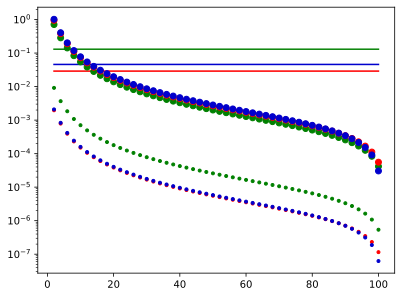

0.13055220578372834 0.009168490335072443 0.710383041405096


<Figure size 640x480 with 0 Axes>

In [15]:
#Parasitic-Qubit Mode Coupling Strengths (only even terms)
pq1=[0]
pq2=[0]
pq3=[0]
for i in range(1,N):
    if np.mod(i,2)==0:
        pq1.append(r*np.sqrt(2/N)*Charge1*E1[i]*c(i,N)/Eg/s(i,N)**2)
        pq2.append(r*np.sqrt(2/N)*Charge2*E2[i]*c(i,N)/Eg/s(i,N)**2)
        pq3.append(r*np.sqrt(2/(N-1))*Charge3*E3[i]*c(i,N-1)/Eg/s(i,N-1)**2)
    else:
        pq1.append(0)
        pq2.append(0)
        pq3.append(0)
f=np.mod(N,2)
plt.plot(n[2::2],[Cq1]*(int(N/2)-1+f),'-',color='green',label='Qubit-Readout Coupling-H1')
plt.plot(n[2::2],[Cq2]*(int(N/2)-1+f),'-',color='red',label='Qubit-Readout Coupling-H2')
plt.plot(n[2::2],[Cq3]*(int(N/2)-1+f),'-',color='mediumblue',label='Qubit-Readout Coupling-H3')
plt.plot(n[2::2],Cp1[2::2],'.',color='green',label='Parasitic-Readout Coupling-H1')
plt.plot(n[2::2],Cp2[2::2],'.',color='red',label='Parasitic-Readout Coupling-H2')
plt.plot(n[2:-1:2],Cp3[2:-1:2],'.',color='mediumblue',label='Parasitic-Readout Coupling-H3')
plt.plot(n[2::2],pq1[2::2],'o',color='green',label='Qubit-Parasitic-H1')
plt.plot(n[2::2],pq2[2::2],'o',color='red',label='Qubit-Parasitic-H2')
plt.plot(n[2:-1:2],pq3[2:-1:2],'o',color='mediumblue',label='Qubit-Parasitic-H3')
plt.yscale('log')
#plt.xlim(0,N/2)
#plt.ylim(10**(-24),1)
#plt.legend()
plt.show()
plt.savefig('Coupling_Strength.pdf')
print(Cq1,Cp1[2],pq1[2])

### Coupling between qubit and readout (g)

In [16]:
zpf_p1=((EJJ/N/8/Charge1)**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p2=((EJJ/N/8/Charge2)**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p3=((EJJ/N/8/Charge3)**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
#under this assumption, zpf_p=1/zpf_x and x,p are defined as (a-a^\dagger)/sqrt(2)
print("Fluxonium Zero-point fluctuation of charge(n) operator for H_1:",zpf_p1)#Emma's is 0.35
print("Fluxonium Zero-point fluctuation of charge(n) operator for H_2:",zpf_p2)#Emma's is 0.35
print("Fluxonium Zero-point fluctuation of charge(n) operator for H_3:",zpf_p3)#Emma's is 0.35
zpf_pr=((ELr/8/ECr)**(1/4))/np.sqrt(2)
print("Resonator Zero-point fluctuation of charge(n) operator:",zpf_pr)#Emma says this should be 2.84
VZPF=4*ECr*zpf_pr
#Since zero point fluctuations are untiless, Emma quoted the coefficient of the p_\phi p_r term and not n_\phi n_r
print("Coupling coefficient of p_\phi p_r in GHz for H_1:",Cq1*VZPF*zpf_p1)#Emma's calc says this is 0.026MHz
print("Coupling coefficient of p_\phi p_r in GHz for H_2:",Cq2*VZPF*zpf_p2)#Emma's calc says this is 0.026MHz
print("Coupling coefficient of p_\phi p_r in GHz for H_3:",Cq3*VZPF*zpf_p3)#Emma's calc says this is 0.026MHz
print(zpf_p1,zpf_p2,zpf_p3)
print(Cq1,Cq2,Cq3)#the total capacitance of the two circuits changed considerably
#If we are working with charge and not momentum then we should use Cq1*VZPF and not multiply zpf_p1

Fluxonium Zero-point fluctuation of charge(n) operator for H_1: 0.37498401689125493
Fluxonium Zero-point fluctuation of charge(n) operator for H_2: 0.3488100140532351
Fluxonium Zero-point fluctuation of charge(n) operator for H_3: 0.3421958004809281
Resonator Zero-point fluctuation of charge(n) operator: 2.839198711323578
Coupling coefficient of p_\phi p_r in GHz for H_1: 0.03663027536748641
Coupling coefficient of p_\phi p_r in GHz for H_2: 0.007577359900911435
Coupling coefficient of p_\phi p_r in GHz for H_3: 0.011742726757084126
0.37498401689125493 0.3488100140532351 0.3421958004809281
0.13055220578372834 0.029032588473736604 0.04586179697045908


In [17]:
E=((e_c/294)*(e_c/19.4)/(e_c/294+e_c/19.4+e_c/1))*tpi#E_cr*E_\phi/(E_cr+E_\phi+E_c)
print(8*Charge1*ECr/Ec*zpf_pr)
print(8*E*2.84)

0.09768489780221529
0.07314136783384664


In [18]:
print(((EJJ/8/E1[2])**(1/4))/np.sqrt(2))

1.621696788372734


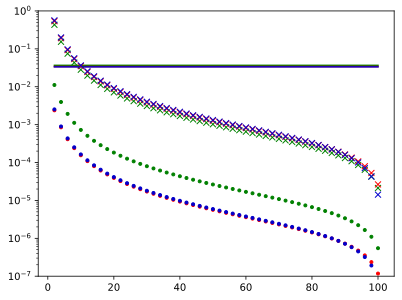

In [19]:
#Absolute parasitic-qubit coupling
zpf_pp1=[0]+[((EJJ/8/E1[i])**(1/4))/np.sqrt(2) for i in range(1,N)] #what are the zero point fluctuation values?
zpf_pp2=[0]+[((EJJ/8/E2[i])**(1/4))/np.sqrt(2) for i in range(1,N)] #what are the zero point fluctuation values?
zpf_pp3=[0]+[((EJJ/8/E3[i])**(1/4))/np.sqrt(2) for i in range(1,N)] #what are the zero point fluctuation values?
#zpf's are multiplied for parasitic mode and qubit mode but not the readout mode. So we only care about VZPF here

#coefficients to be used with the charge operators
gq1=np.array(Cq1)*VZPF
gq2=np.array(Cq1)*VZPF
gq3=np.array(Cq1)*VZPF

gp1=np.array(Cp1)*VZPF
gp2=np.array(Cp2)*VZPF
gp3=np.array(Cp3)*VZPF

gpq1=np.array(pq1)
gpq2=np.array(pq2)
gpq3=np.array(pq3)


#coupling strengths
g_q1=np.array(Cq1)*VZPF*zpf_p1
g_q2=np.array(Cq1)*VZPF*zpf_p2
g_q3=np.array(Cq1)*VZPF*zpf_p3

g_p1=np.array(Cp1)*VZPF*zpf_pp1
g_p2=np.array(Cp2)*VZPF*zpf_pp2
g_p3=np.array(Cp3)*VZPF*zpf_pp3

g_pq1=np.array(pq1)*zpf_p1*zpf_pp1
g_pq2=np.array(pq2)*zpf_p2*zpf_pp2
g_pq3=np.array(pq3)*zpf_p3*zpf_pp3

plt.plot(n[2::2],[g_q1]*(int(N/2)-1+f),'-',color='green',label='Qubit-Readout Coupling-H1')
plt.plot(n[2::2],[g_q2]*(int(N/2)-1+f),'-',color='red',label='Qubit-Readout Coupling-H2')
plt.plot(n[2::2],[g_q3]*(int(N/2)-1+f),'-',color='mediumblue',label='Qubit-Readout Coupling-H3')
plt.plot(n[2::2],g_p1[2::2],'.',color='green',label='Parasitic-Readout Coupling-H1')
plt.plot(n[2::2],g_p2[2::2],'.',color='red',label='Parasitic-Readout Coupling-H2')
plt.plot(n[2:-1:2],g_p3[2:-1:2],'.',color='mediumblue',label='Parasitic-Readout Coupling-H3')
plt.plot(n[2::2],g_pq1[2::2],'x',color='green',label='Qubit-Parasitic-H1')
plt.plot(n[2::2],g_pq2[2::2],'x',color='red',label='Qubit-Parasitic-H2')
plt.plot(n[2:-1:2],g_pq3[2:-1:2],'x',color='mediumblue',label='Qubit-Parasitic-H3')
plt.yscale('log')
#plt.xlim(0,N/2)
plt.ylim(10**(-7),1)
#plt.legend()
plt.savefig('Coupling_Strength.pdf')
plt.show()

In [20]:
np.save("g_q1-Will.npy",g_q1)
np.save("g_q2-Will.npy",g_q2)
np.save("g_q3-Will.npy",g_q3)
np.save("g_p1-Will.npy",g_p1)
np.save("g_p2-Will.npy",g_p2)
np.save("g_p3-Will.npy",g_p3)
np.save("g_pq1-Will.npy",g_pq1)
np.save("g_pq2-Will.npy",g_pq2)
np.save("g_pq3-Will.npy",g_pq3)

In [22]:
print(g_q1,g_p1[2],g_pq1[2])
print(Charge1, EJJ/N,omega1[2],gq1,gp1[2],gpq1[2])


0.03663027536748641 0.011125273610528915 0.4319912983302271
1.2644130824354534 0.7999999999999999 15.513895074122967 0.0976848978022153 0.006860267400351946 0.710383041405096


### Charge Martix Elements (Numerical Diagonalization)

-2.700213296254295
-2.7272727272727275


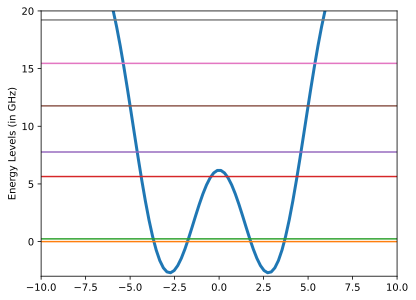

In [33]:
x=np.linspace(-10,10,100)
import math as ma
def y(x,a,b):
    return (a*np.cos(x)+(b/2)*x**2)
def y1(x,a,b):#upto 20 terms we can determine the behaviour of the well here!
    N=21
    c=(b/2)*x**2
    for i in range(0,N,2):
        c=c+(-1)**(i/2)*a/ma.factorial(i)*(x**i)
    return c

def y2(x,a,b,a1,b1):
    N=3
    c=0
    if np.abs(x)<np.abs(np.abs(x)-3):
        c=(b1/2)*x**2
        for i in range(0,N,2):
            c=c+(-1)**(i/2)*a1/ma.factorial(i)*(x**i)
    else:    
        for i in range(0,N,2):
            if np.abs(x-b)<np.abs(x+b):
                c=c+(-1)**(i/2)*a/ma.factorial(i)*((x-b)**i)
            else:
                c=c+(-1)**(i/2)*a/ma.factorial(i)*((x+b)**i)
    return c
y=[y(i,EJ1,EJJ/N) for i in x]#fluxonium at half flux because cosine has the same sign as x^2!
y1=[y1(i,EJ1,EJJ/N) for i in x]#fluxonium at half flux because cosine has the same sign as x^2!
print(min(y))
y2=[y2(i,min(y),x[np.argmin(y)],EJ1,EJJ/N) for i in x]#fluxonium at half flux because cosine has the same sign as x^2!
plt.plot(x,y,linewidth=3)
#plt.plot(x,y1)
#plt.plot(x,y2)
plt.ylim(-3,20)
plt.xlim(-10,10)
for i in range(10):
    plt.plot(x,[flux_e1[i]-flux_e1[0]]*100)
plt.ylabel('Energy Levels (in GHz)')
print(x[np.argmin(y)])
#plt.savefig("potential_Will.pdf")


In [34]:
np.save("energy_Will.npy",flux_e1)

In [35]:
## Fluxonium Hamiltonian
# There is something weird here. The zero-point fluctuations should have the units of energy! 
# We know that the zero-point fluctuations of n is constant
# For zero-point fluctuations in flux, this should also be a constant! 


In [36]:
Ncav=100
a=destroy(Ncav)
ad=a.dag()
EL=EJJ/N
zpf_x=(((8*Charge1)/(EJJ/N))**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p=1/(2*zpf_x) #what are the zero point fluctuation values?
nOp1=-1j*(a-ad)*zpf_p
fOp1=(a+ad)*zpf_x
cosfOp1=((1j*fOp1).expm()+(-1j*fOp1).expm())/2
H1=4*(Charge1)*(nOp1**2)+(EJ1)*cosfOp1+0.5*(EL)*fOp1**2# in GHz not omega
print("Emma's Zero-point fluctuation of phase operator:",1.4)
print("My Zero-point fluctuation of phase operator for H_1:",zpf_x)
print("My Zero-point fluctuation of charge operator for H_1:",1/2/zpf_x)
#Now keep only 20 levels in this basis to define the new charge operator and the flux operator!
#H1_trun=[flux_e1[i]*ket2dm(Qobj(flux_s1[i])) for i in range(20)]

Emma's Zero-point fluctuation of phase operator: 1.4
My Zero-point fluctuation of phase operator for H_1: 1.333390164586667
My Zero-point fluctuation of charge operator for H_1: 0.374984016891255


In [37]:
#Fluxonium Hamiltonian
zpf_x2=(((8*Charge2)/(EJJ/N))**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p2=1/2/zpf_x2#what are the zero point fluctuation values?
pOp2=-1j*(a-ad)
xOp2=(a+ad)
nOp2=-pOp2*zpf_p2
fOp2=xOp2*zpf_x2
cosfOp2=((1j*fOp2).expm()+(-1j*fOp2).expm())/2
H2=4*(Charge2)*nOp2**2+(EJ1)*cosfOp2+0.5*(EJJ/N)*fOp2**2
print("My Zero-point fluctuation of phase operator for H_2:",zpf_x2)

My Zero-point fluctuation of phase operator for H_2: 1.4334450843022253


In [38]:
#Fluxonium Hamiltonian
zpf_x3=(((8*Charge3)/(EJJ/(N-1)))**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p3=1/2/zpf_x3#what are the zero point fluctuation values?
pOp3=-1j*(a-ad)
xOp3=(a+ad)
nOp3=-pOp3*zpf_p3
fOp3=xOp3*zpf_x3
cosfOp3=((1j*fOp3).expm()+(-1j*fOp3).expm())/2
H3=4*(Charge3)*nOp3**2+(EJ1)*cosfOp3+0.5*(EJJ/(N-1))*fOp3**2
print("My Zero-point fluctuation of phase operator for H_3:",zpf_x3)

My Zero-point fluctuation of phase operator for H_3: 1.4575572747610979


In [39]:
flux_e1,flux_s1=H1.eigenstates()
flux_e2,flux_s2=H2.eigenstates()
flux_e3,flux_s3=H3.eigenstates()

In [40]:
print(r'$\omega_{10}$:',flux_e1[1]-flux_e1[0])#Emma's value=0.0337 GHz
print(r'$\omega_{10}$:',flux_e2[1]-flux_e2[0])#Emma's value=0.0337 GHz
print(r'$\omega_{10}$:',flux_e2[1]-flux_e2[0])#Emma's value=0.0337 GHz
print(r'$\omega_{12}$:',flux_e1[2]-flux_e1[1])#Emma's value=6.082 GHz
print(r'$\omega_{12}$:',flux_e2[2]-flux_e2[1])#Emma's value=6.082 GHz
print(r'$\omega_{12}$:',flux_e3[2]-flux_e3[1])#Emma's value=6.082 GHz

$\omega_{10}$: 0.23574584823000932
$\omega_{10}$: 0.45899140856533904
$\omega_{10}$: 0.45899140856533904
$\omega_{12}$: 5.4053030281649335
$\omega_{12}$: 5.875424422732635
$\omega_{12}$: 6.017432273541203


In [41]:
#We replace this by Charge1 and we get a completely different number!
import scqubits as scq
from scqubits import Fluxonium
#This Hamiltonian takes information related to zero-point fluctuations when we compute charge elements
fluxonium = scq.Fluxonium(EJ = EJ1,
                               EC = Charge1,#EC1
                               EL = EJJ/N,
                               flux = 0.5,
                               cutoff = 100)
H=Qobj(fluxonium.hamiltonian())
sc_n=Qobj(fluxonium.n_operator())#this n operator has the zpf included
flux_e,flux_s=H.eigenstates()
print(flux_e[1]-flux_e[0])
print(flux_e[2]-flux_e[1])
print(Charge1, EJJ/N,EJ1)

0.23574584823004519
5.405303028164904
1.2644130824354534 0.7999999999999999 6.2


Text(0.5, 0, 'qubit-eigenmodes')

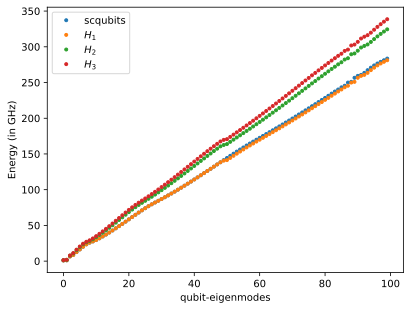

In [42]:
#energies are in GHz not omega
#We have confirmed that energies for H1, H2, H3 agree with scqubits
plt.plot(flux_e,'.',label='scqubits')
plt.plot(flux_e1,'.',label=r'$H_1$')
plt.plot(flux_e2,'.',label=r'$H_2$')
plt.plot(flux_e3,'.',label=r'$H_3$')
plt.legend()
plt.ylabel('Energy (in GHz)')
plt.xlabel('qubit-eigenmodes')

for the first few modes our result is the same as scqubits


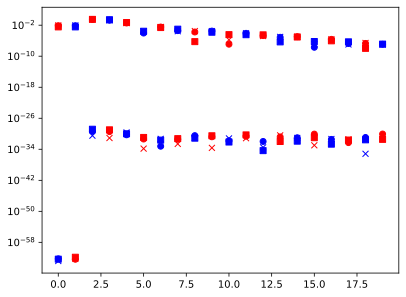

In [49]:
def charge_mat1(m,n):
    return np.abs(((Qobj(flux_s1[n]).dag())*nOp1*Qobj(flux_s1[m])))**2
def charge_mat2(m,n):
    return np.abs(((Qobj(flux_s2[n]).dag())*nOp2*Qobj(flux_s2[m])))**2
def charge_mat3(m,n):
    return np.abs(((Qobj(flux_s3[n]).dag())*nOp3*Qobj(flux_s3[m])))**2
p10=[charge_mat1(0,l) for l in range(Ncav)]
p11=[charge_mat1(1,l) for l in range(Ncav)]
p12=[charge_mat1(2,l) for l in range(Ncav)]
p20=[charge_mat2(0,l) for l in range(Ncav)]
p21=[charge_mat2(1,l) for l in range(Ncav)]
p22=[charge_mat2(2,l) for l in range(Ncav)]
p30=[charge_mat3(0,l) for l in range(Ncav)]
p31=[charge_mat3(1,l) for l in range(Ncav)]
p32=[charge_mat3(2,l) for l in range(Ncav)]
np.save("charge_10-Will.npy",p10)
np.save("charge_11-Will.npy",p11)
np.save("charge_12-Will.npy",p12)
np.save("charge_20-Will.npy",p20)
np.save("charge_21-Will.npy",p21)
np.save("charge_22-Will.npy",p22)
np.save("charge_30-Will.npy",p30)
np.save("charge_31-Will.npy",p31)
np.save("charge_32-Will.npy",p32)

plt.plot(p10[:20],'s',color='blue',label=r'$H_1:|\langle 0|n_\phi|l\rangle|^2$')
plt.plot(p11[:20],'s',color='red',label=r'$H_1:|\langle 1|n_\phi|l\rangle|^2$')
plt.plot(p20[:20],'o',color='blue',label=r'$H_2:|\langle 0|n_\phi|l\rangle|^2$')
plt.plot(p21[:20],'o',color='red',label=r'$H_2:|\langle 1|n_\phi|l\rangle|^2$')
plt.plot(p30[:20],'x',color='blue',label=r'$H_3:|\langle 0|n_\phi|l\rangle|^2$')
plt.plot(p31[:20],'x',color='red',label=r'$H_3:|\langle 1|n_\phi|l\rangle|^2$')
plt.yscale('log')
#plt.ylim(10**(-15),1)
#plt.legend()
print('for the first few modes our result is the same as scqubits')